# Opacity Package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use(['seaborn', {'figure.dpi':100}])

import dsharp_opac as opacity

# Comparison of Optical Constants
This part compares the actual optical constants that the package uses to the files I received from Luca Ricci.

### Silicates
There are some differences, Luca Riccis data seems to be identical with [Weingartner & Draine 2001](https://dx.doi.org/10.1086/32085). We are using the [Draine 2003](https://dx.doi.org/10.1086/379123) implemented in `diel_draine2003`.

Please cite Ricci et al. (2010) when using these optical constants, or the specific reference for that species
Please cite Weingartner & Draine (2001) when using these optical constants
Please cite Draine 2003 when using these optical constants


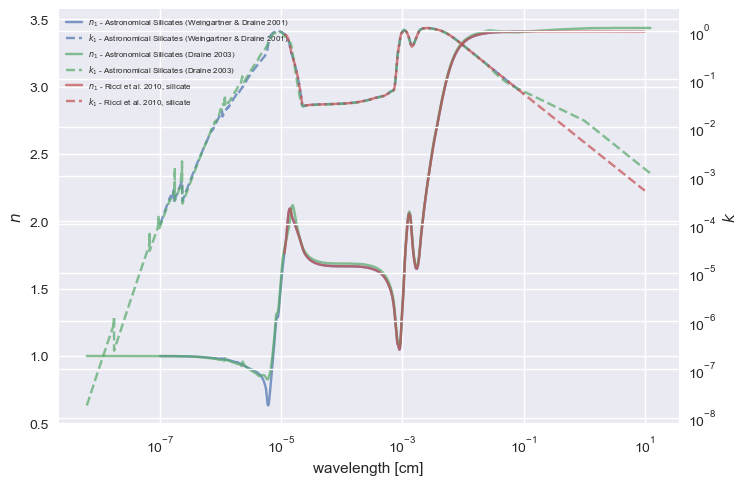

In [2]:
r = opacity.diel_ricci10('silicate', extrapol=True)
c1 = opacity.diel_WeingartnerDraine2001_astrosil()
c2 = opacity.diel_draine2003('astrosilicates')
opacity.compare_nk([c1, c2, r], orig_data=True);

### Carbonaceous Material
Comparing the carbonaceous grain data: good match, but the data in Zubko ends at 0.9 mm (1.358 meV). Data beyond that is apparently extrapolated. Our version of the Zubko et al. 1996 data uses the extrapolation with default parameters to give a similar result

Please cite Ricci et al. (2010) when using these optical constants, or the specific reference for that species
Please cite Zubko et al. (1996) when using these optical constants
Please cite Zubko et al. (1996) when using these optical constants


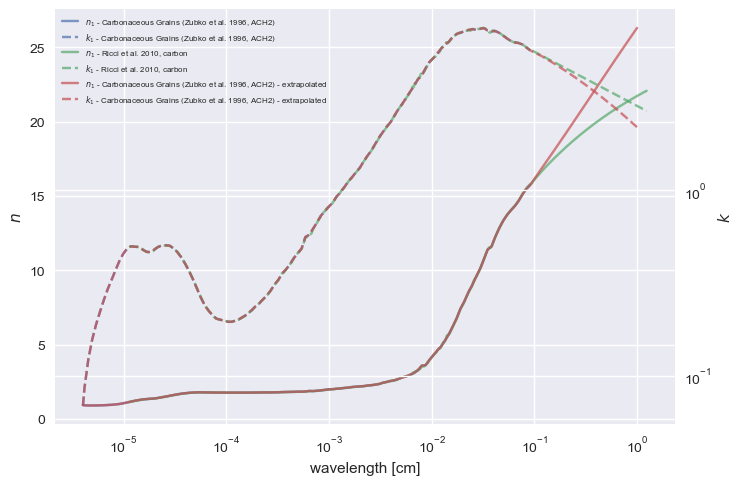

In [3]:
r = opacity.diel_ricci10('carbon')
c = opacity.diel_zubko96()
ce = opacity.diel_zubko96(extrapol=True)
opacity.compare_nk([c, r, ce], orig_data=True);

### Water Ice
And now the water ice comparison: it is unclear to me where Luca Ricci data comes from. His thesis mentions only Warren 1984, but those constants only go to 4.43e-6 cm, while his extends down to 4.14e-09. The header mentions *extended to X-rays by V. Zubko*. Furthermore his long wavelengths $k$ values are neither the old Warren 1984 data nor the new ones. It looks like they are somewhere between the -20 and -5 ºC data of Warren 1984. We will use the newer values from Warren & Brandt (2008).

Please cite Ricci et al. (2010) when using these optical constants, or the specific reference for that species
Please cite Warren & Brandt (2008) when using these optical constants
Please cite Warren (1984) when using these optical constants


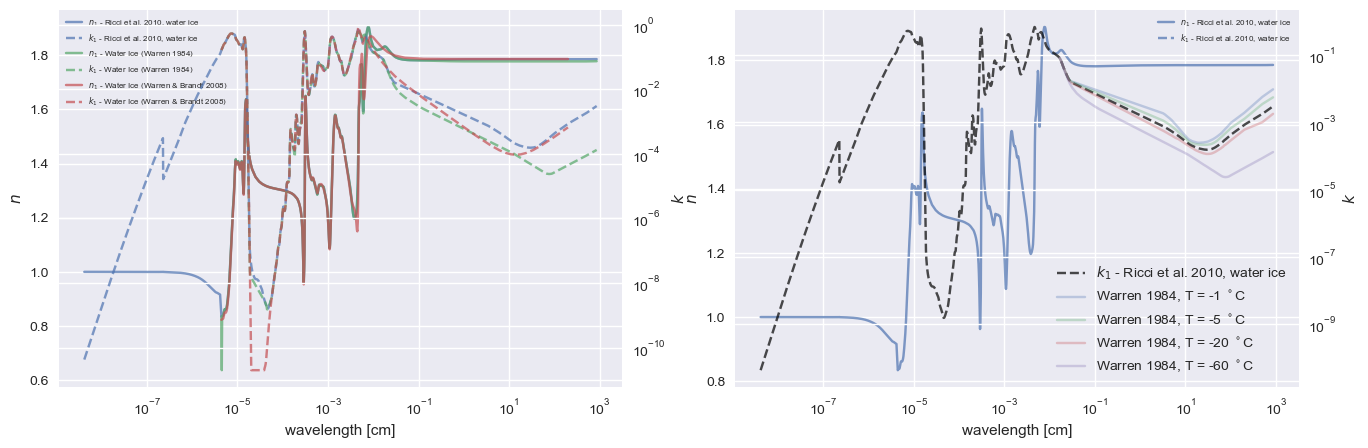

In [4]:
file = os.path.join(os.path.dirname(opacity.__file__),'optical_constants', 'warren', 'warren_1984_all_temps.txt')
lam, n1, k1, n2, k2, n3, k3, n4, k4 = np.loadtxt(file).T
T = [-1,-5,-20,-60]

r = opacity.diel_ricci10('ice')
c = opacity.diel_warrenbrandt08()
co = opacity.diel_warren84()

f, axs = plt.subplots(1, 2, figsize=(16, 5))

opacity.compare_nk([r, co, c], orig_data=True, ax=axs[0])

f, ax = opacity.compare_nk([r], orig_data=True, ax=axs[1])

for l in ax.get_lines()[:2]:
    l.set_color('k')
for _T,k in zip(T,[k1, k2, k3, k4]):
    ax.loglog(lam*1e-4,k,'-',label=f'Warren 1984, T = {_T} $^\circ$C', alpha=0.3)
ax.legend();

# Comparison of mixed optical constants

We will compare how the Bruggeman-mixed optical constants based on Luca Riccis data and our optical constants. Only differences are in the long wavelength tail that comes from the extrapolation of the carbonaceous data.

Please cite Ricci et al. (2010) when using these optical constants, or the specific reference for that species
Please cite Ricci et al. (2010) when using these optical constants, or the specific reference for that species
Please cite Ricci et al. (2010) when using these optical constants, or the specific reference for that species
Please cite Draine 2003 when using these optical constants
Please cite Zubko et al. (1996) when using these optical constants
Please cite Warren & Brandt (2008) when using these optical constants


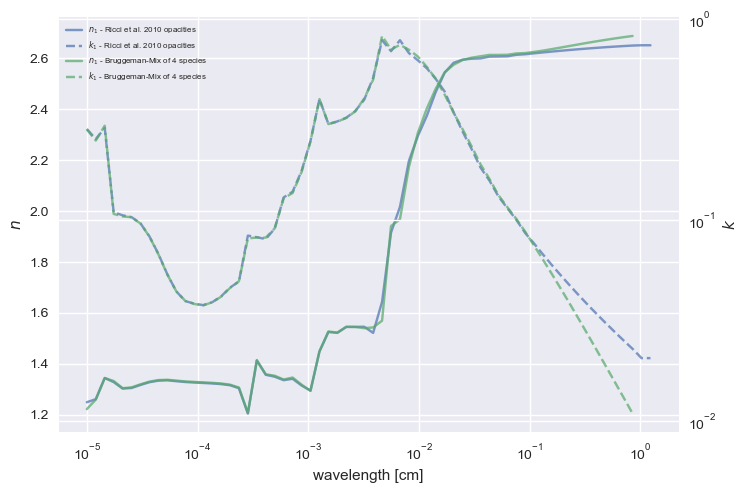

In [5]:
# after Luca Riccis thesis, the fractions in Ricci+2010 are typos

r1 = opacity.diel_ricci10('silicate', extrapol=True, lmin=1e-6, lmax=1.0)
r2 = opacity.diel_ricci10('carbon', extrapol=True, lmin=1e-6, lmax=1.0)
r3 = opacity.diel_ricci10('ice', extrapol=True, lmin=1e-6, lmax=1.0)
r4 = opacity.diel_vacuum()

vol_fract = [0.07, 0.21, 0.42, 0.30]
densities = [3.50, 2.50, 1.00, 0.00]
rho_ricci = np.sum(vol_fract * np.array(densities))

dc_ricci = opacity.diel_mixed([r1, r2, r3, r4], vol_fract, rule='Bruggeman')
dc_ricci.material_str='Ricci et al. 2010 opacities'


d1 = opacity.diel_draine2003('astrosilicates')
d2 = opacity.diel_zubko96()
d2.extrapolate_constants_up(0.07, 1, kind='first')
d3 = opacity.diel_warrenbrandt08()
d4 = opacity.diel_vacuum()

dc_lit = opacity.diel_mixed([d1, d2, d3, d4], vol_fract, rule='Bruggeman')

opacity.compare_nk([dc_ricci, dc_lit]);

# Compare old (Luca Riccis files) and new opacities (literature data, this Mie code)

Set up particle size and wavelength grid

In [6]:
a = np.logspace(-5, 2, 200)
lam = np.logspace(np.log10(6.5e-6), 0, 206)

Calculate opacities

In [7]:
res_l = opacity.get_opacities(a, lam, rho_ricci, dc_ricci, extrapol=True, return_all=True, extrapolate_large_grains=True)
kappa_abs_l = res_l['k_abs']
kappa_sca_l = res_l['k_sca']
gg_sca_l    = res_l['g']

res_r = opacity.get_opacities(a, lam, rho_ricci, dc_lit, extrapol=True, return_all=True, extrapolate_large_grains=True)
kappa_abs_r = res_r['k_abs']
kappa_sca_r = res_r['k_sca']
gg_sca_r    = res_r['g']

Mie ... Done!
Mie ... Done!


Load new opacities

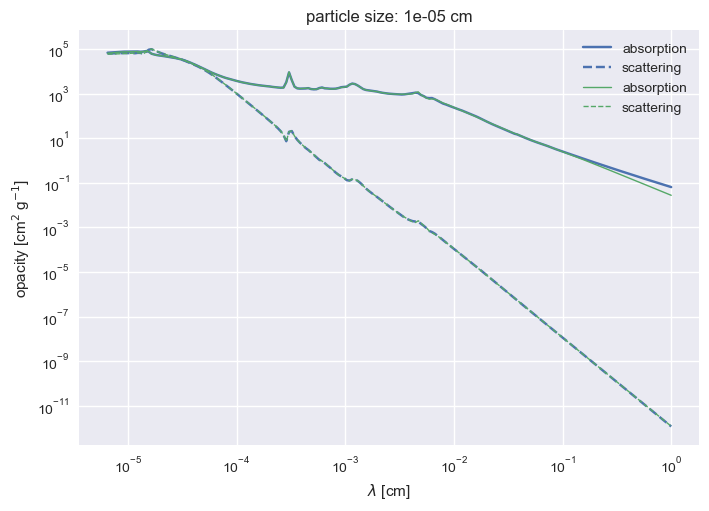

In [8]:
f, ax = plt.subplots()

ax.loglog(lam, kappa_abs_l[0, :], c='C0', ls='-', label='absorption')
ax.loglog(lam, kappa_sca_l[0, :], c='C0', ls='--', label='scattering')

ax.loglog(lam, kappa_abs_r[0, :], c='C1', lw=1, ls='-', label='absorption')
ax.loglog(lam, kappa_sca_r[0, :], c='C1', lw=1, ls='--', label='scattering')

ax.set_title(f'particle size: {a[0]} cm')
ax.set_ylabel('opacity [cm$^2$ g$^{-1}$]')
ax.set_xlabel('$\lambda$ [cm]')
ax.legend();

# Package Tests

## Test the extrapolation of optical constants

Please cite Draine 2003 when using these optical constants
Please cite Draine 2003 when using these optical constants


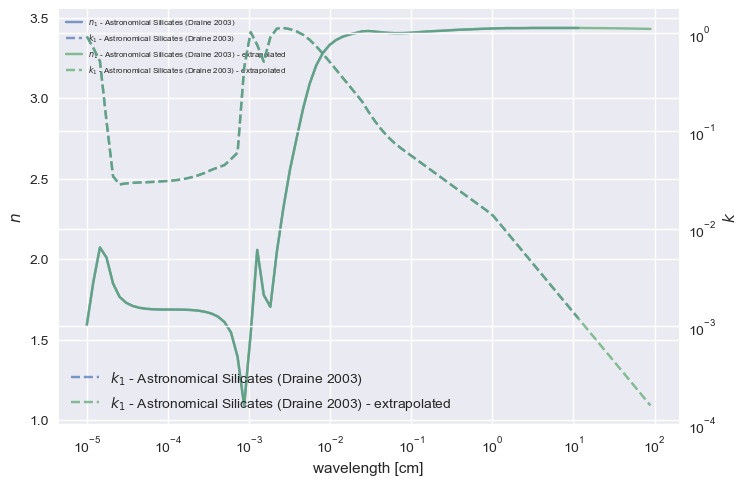

In [9]:
dc_ext = opacity.diel_draine2003('astrosilicates')
dc_ext.extrapolate_constants_up(1e0,1e2)
dc_orig = opacity.diel_draine2003('astrosilicates')
opacity.compare_nk([dc_orig, dc_ext])
ax = plt.gca()
for l in ax.get_lines()[-4:-2]: l.set_linewidth(3)
ax.legend();

Please cite Zubko et al. (1996) when using these optical constants
Please cite Zubko et al. (1996) when using these optical constants


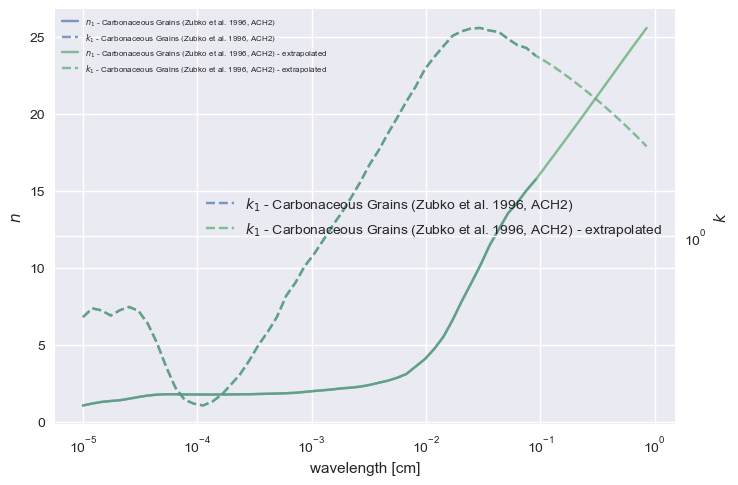

In [10]:
dc_orig = opacity.diel_zubko96(extrapol=False)
dc_extr = opacity.diel_zubko96(extrapol=False)
dc_extr.extrapolate_constants_up(5e-2, 1)
opacity.compare_nk([dc_orig, dc_extr])
ax = plt.gca()
for l in ax.get_lines()[-4:-2]: l.set_linewidth(3)
ax.legend();

# Compare the different BH Mie implementations

In [11]:
x = 1
dc = opacity.get_dsharp_mix()[0]
n,k = dc.nk(1e-4)

Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| Astronomical Silicates (Draine 2003)| 0.167            | 0.329          |
| Troilite (Henning)                  | 0.02578          | 0.07434        |
| Organics (Henning)                  | 0.443            | 0.3966         |


**Time the python version without numba (but coating)**

In [12]:
res = opacity.dsharp_opac.bhmie_pymiecoated(x, complex(n,k), 3)
print(f' Qext = {res[2]}')
print(f' QABS = {res[3]}')
print(f' QSCA = {res[4]}')
print(f' GSCA = {res[6]}')

 Qext = 0.3239727185596973
 QABS = 0.04912968446490967
 QSCA = 0.2748430340947876
 GSCA = 0.20759914145740327


In [13]:
%timeit res = opacity.dsharp_opac.bhmie_pymiecoated(x, complex(n,k), 3)

522 µs ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**Time the python version with numba**

In [14]:
res = opacity.bhmie_python(x, complex(n,k),np.linspace(0, 180, 3))
print(f' Qext = {res[2]}')
print(f' QABS = {res[3]}')
print(f' QSCA = {res[4]}')
print(f' GSCA = {res[6]}')

 Qext = 0.3239727185596978
 QABS = 0.04912968446490962
 QSCA = 0.27484303409478816
 GSCA = 0.2075991414574046


In [15]:
%timeit res = opacity.bhmie_python(x, complex(n,k),np.linspace(0, 180, 3))

49.3 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Time the fortran version**

In [16]:
res = opacity.bhmie_fortran(x, complex(n,k), 3)
print(f' Qext = {res[2]}')
print(f' QABS = {res[3]}')
print(f' QSCA = {res[4]}')
print(f' GSCA = {res[6]}')

 Qext = 0.3239727020263672
 QABS = 0.04912969470024109
 QSCA = 0.2748430073261261
 GSCA = 0.20759916305541992


In [17]:
%timeit res = opacity.bhmie_fortran(x, complex(n,k), 3)

2.61 µs ± 18.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
